##Uplift Modeling

##Install and Load Packages

In [ ]:
!pip install causalml
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from causalml.inference.meta import BaseSClassifier
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from IPython.display import Image

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 25
sns.set()

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


##Load Dataset

In [ ]:
raw_data = pd.read_csv("/content/data.csv")

##Data Inspection

In [ ]:
raw_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
raw_data.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Select only the numeric columns of the DataFrame for correlation calculation
numeric_data = raw_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
print(correlation_matrix)


                recency   history  used_discount  used_bogo  is_referral  \
recency        1.000000 -0.246591      -0.031336  -0.026617    -0.052106   
history       -0.246591  1.000000       0.112677   0.114685     0.223279   
used_discount -0.031336  0.112677       1.000000  -0.816943     0.020900   
used_bogo     -0.026617  0.114685      -0.816943   1.000000     0.021346   
is_referral   -0.052106  0.223279       0.020900   0.021346     1.000000   
conversion    -0.074765  0.065153       0.006712   0.051999    -0.073924   

               conversion  
recency         -0.074765  
history          0.065153  
used_discount    0.006712  
used_bogo        0.051999  
is_referral     -0.073924  
conversion       1.000000  


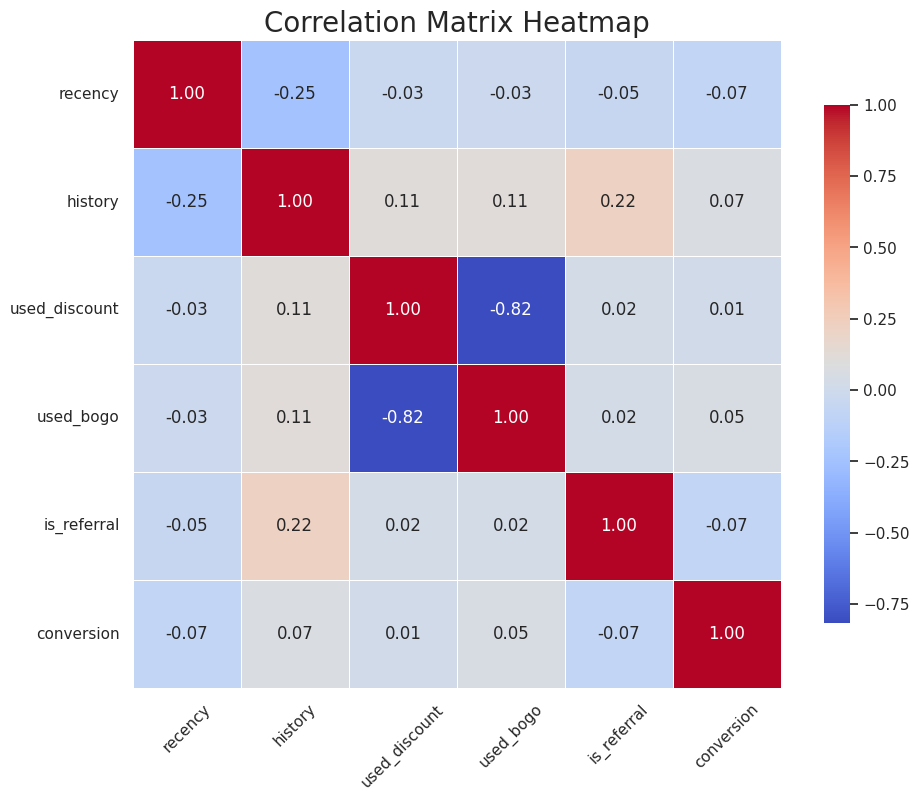

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetics for better readability
sns.set(style="white")

# Create the heatmap, add annotations/colors, and ensure it's readable
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)  # Keep the y labels horizontal for readability

# Show the plot
plt.show()


Initialize Variable

In [ ]:
# treatment variable
treatment_variable = "offer"
# target variable
target_variable = "conversion"
# control category
control_category = "No Offer"
# treatment category
treatment_category = "Discount"
# category to exclude if needed
exclusion_category = None
# column to drop
variable_to_drop = []
# column to encode
categorical_columns = ["zip_code", "channel"]

Check treatment variable distribution

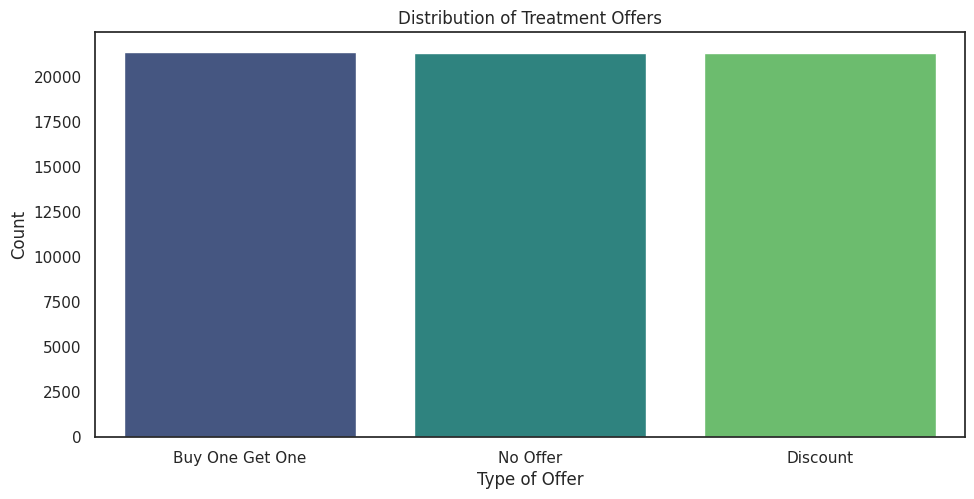

In [ ]:
sns.countplot(data=raw_data, x=treatment_variable, palette='viridis')
plt.title('Distribution of Treatment Offers')
plt.xlabel('Type of Offer')
plt.ylabel('Count')
plt.show()

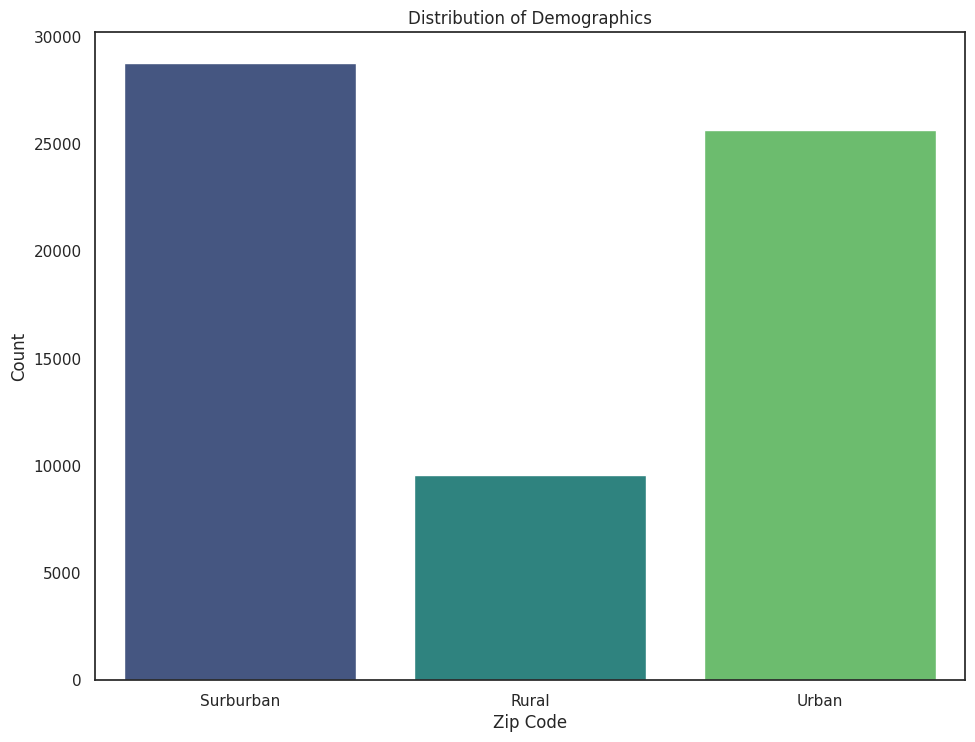

In [ ]:
sns.countplot(data=raw_data, x="zip_code", palette='viridis')
plt.title('Distribution of Demographics')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.show()

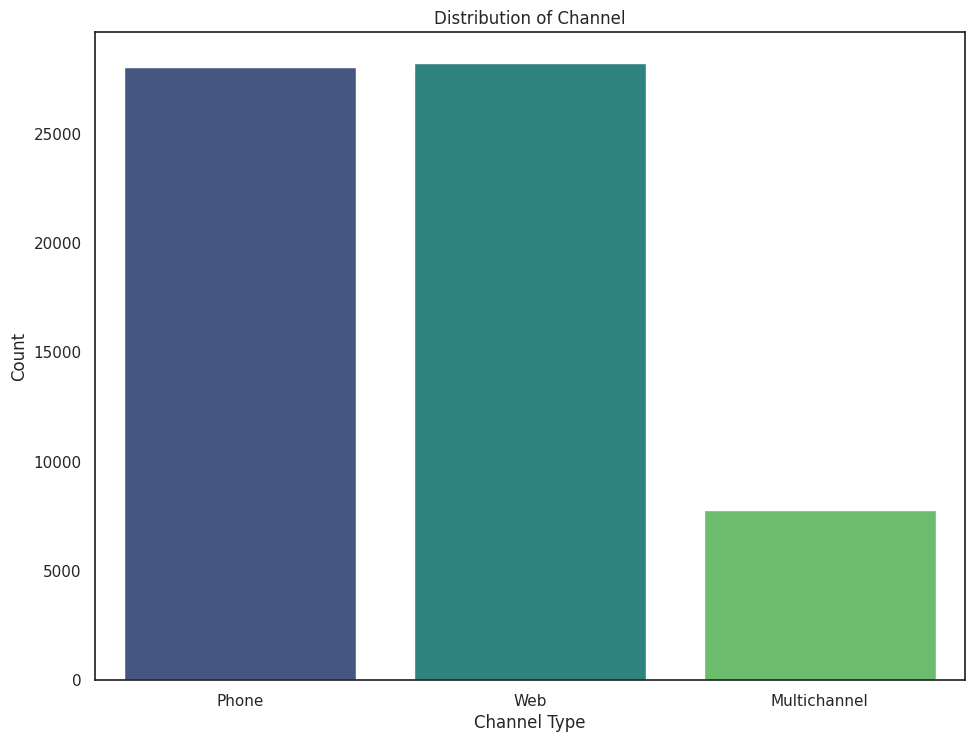

In [ ]:
sns.countplot(data=raw_data, x="channel", palette='viridis')
plt.title('Distribution of Channel')
plt.xlabel('Channel Type')
plt.ylabel('Count')
plt.show()

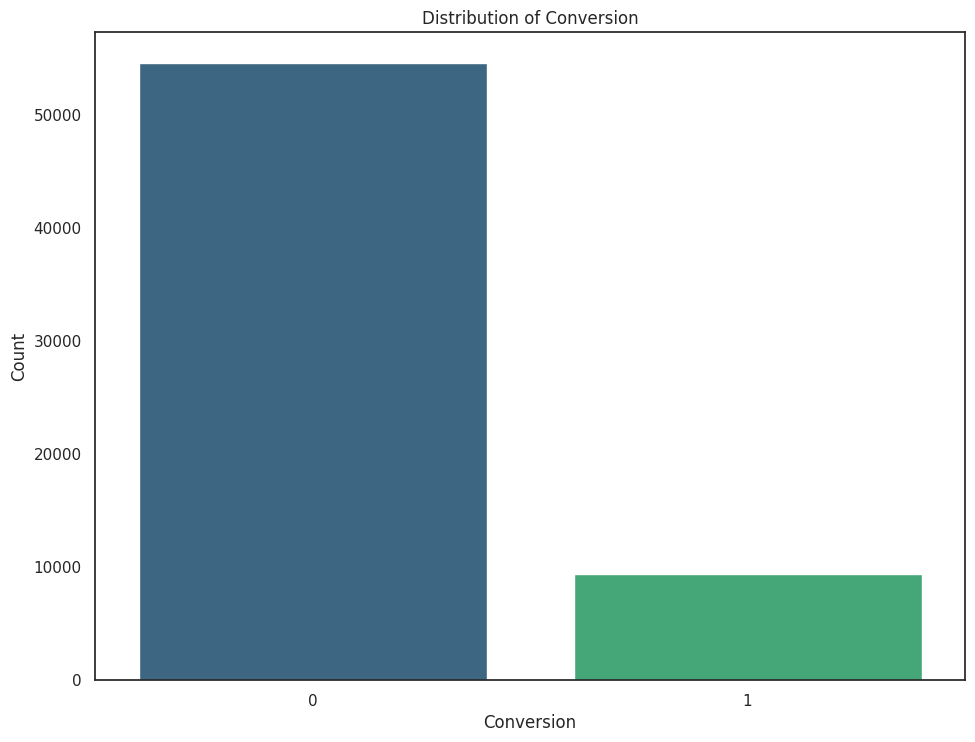

In [ ]:
sns.countplot(data=raw_data, x="conversion", palette='viridis')
plt.title('Distribution of Conversion')
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.show()

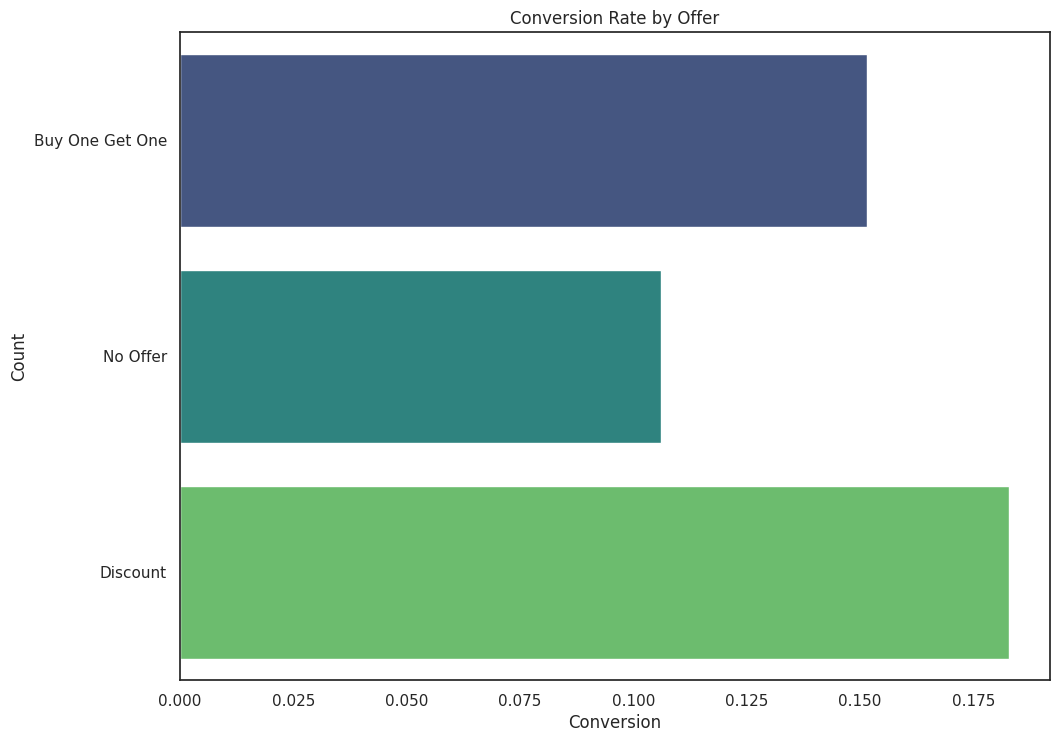

In [ ]:
sns.barplot(data=raw_data, x="conversion", y="offer", palette='viridis', ci=None)
plt.title('Conversion Rate by Offer')
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.show()

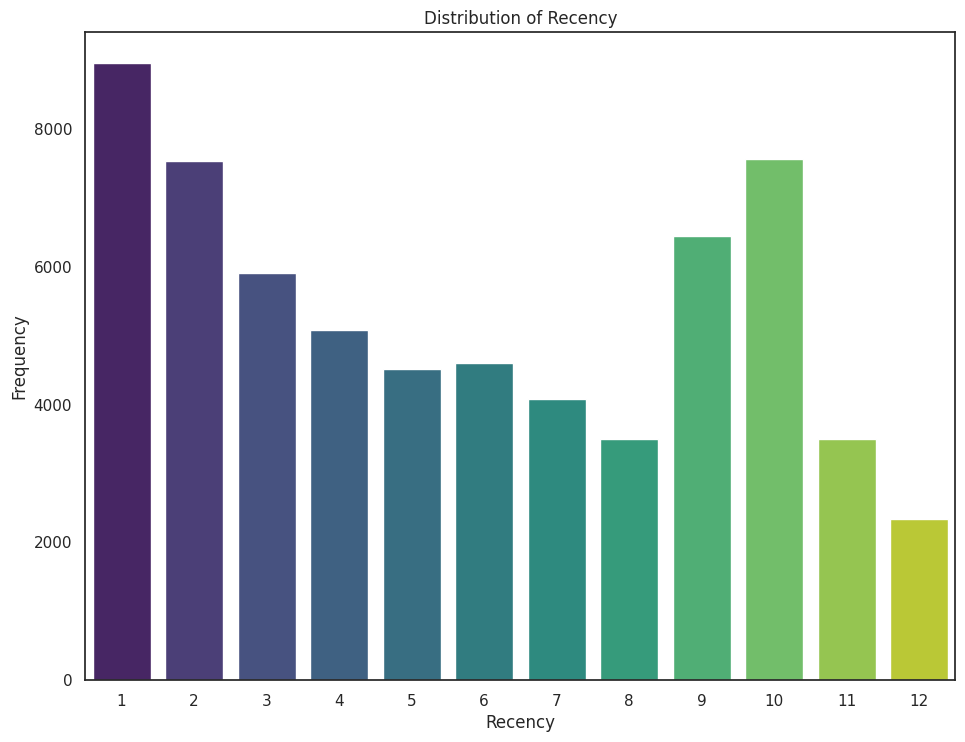

In [ ]:
sns.countplot(data=raw_data, x="recency", palette='viridis')
plt.title('Distribution of Recency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

Remove excluded category

In [ ]:
if exclusion_category != None:
  raw_data = raw_data.loc[raw_data[treatment_variable] != exclusion_category].reset_index(drop=True)

In [ ]:
n_treatment = raw_data[treatment_variable].nunique()

In [ ]:
n_treatment

3

In [ ]:
raw_data.offer.value_counts()

offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64

##Train-Test Split Data

In [ ]:
X_train, X_test = train_test_split(
    raw_data.drop(variable_to_drop, axis = 1),
    test_size = 0.5,
    random_state = 1000
)

#Data Preprocessing and Data Exploration

In [ ]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
18455,10,95.64,1,0,Surburban,0,Phone,Discount,0
44033,9,312.99,0,1,Surburban,1,Multichannel,No Offer,0
60675,1,318.10,0,1,Urban,0,Phone,Discount,0
17443,11,99.42,1,0,Surburban,1,Web,Discount,0
15013,1,382.51,0,1,Urban,0,Phone,No Offer,0


In [ ]:
X_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
6102,3,314.42,0,1,Urban,0,Web,Buy One Get One,0
45109,1,1126.46,1,0,Surburban,1,Web,No Offer,0
26217,2,50.39,1,0,Urban,0,Web,Discount,1
34041,5,156.34,1,0,Urban,0,Web,Discount,0
16367,7,382.71,1,1,Rural,0,Multichannel,Buy One Get One,0


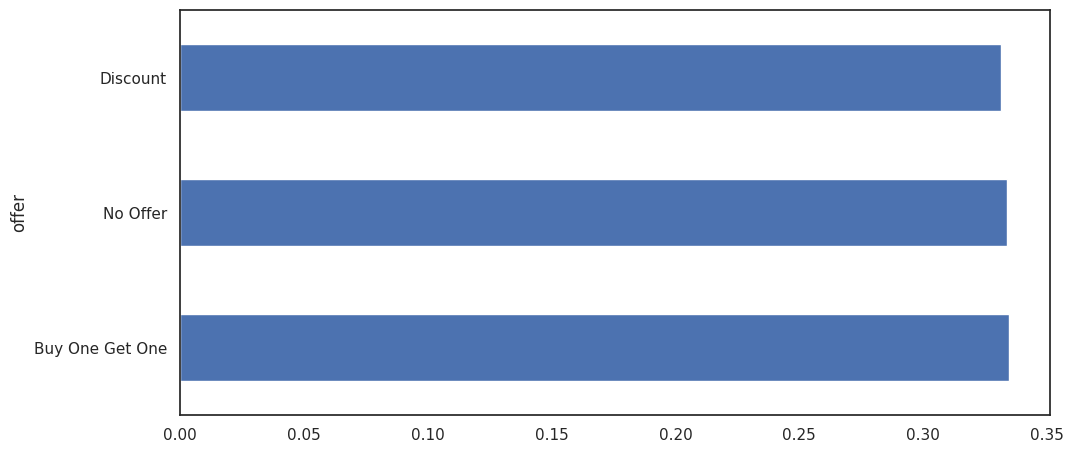

In [ ]:
X_train.offer.value_counts(normalize = True).plot.barh();

Do one-hot encoding for each categorical variable

In [ ]:
# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[categorical_columns], drop_first=True)
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[categorical_columns], drop_first=True)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), dummies], axis=1)

In [ ]:
X_train

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
18455,10,95.64,1,0,0,Discount,0,True,False,True,False
44033,9,312.99,0,1,1,No Offer,0,True,False,False,False
60675,1,318.10,0,1,0,Discount,0,False,True,True,False
17443,11,99.42,1,0,1,Discount,0,True,False,False,True
15013,1,382.51,0,1,0,No Offer,0,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
48379,7,178.90,1,0,0,No Offer,0,False,True,False,True
3776,7,170.43,0,1,0,No Offer,0,False,True,False,True
6215,9,57.06,0,1,0,Buy One Get One,0,False,True,True,False
4695,9,96.24,1,0,0,Buy One Get One,1,True,False,False,True


Check spending history by experiment group

In [ ]:
is_treat = X_train[X_train.offer != control_category]
not_treat = X_train[X_train.offer == control_category]

In [ ]:
is_treat.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
18455,10,95.64,1,0,0,Discount,0,True,False,True,False
60675,1,318.10,0,1,0,Discount,0,False,True,True,False
17443,11,99.42,1,0,1,Discount,0,True,False,False,True
8434,1,107.16,0,1,0,Buy One Get One,1,False,False,True,False
4574,3,136.45,0,1,1,Buy One Get One,0,False,False,True,False


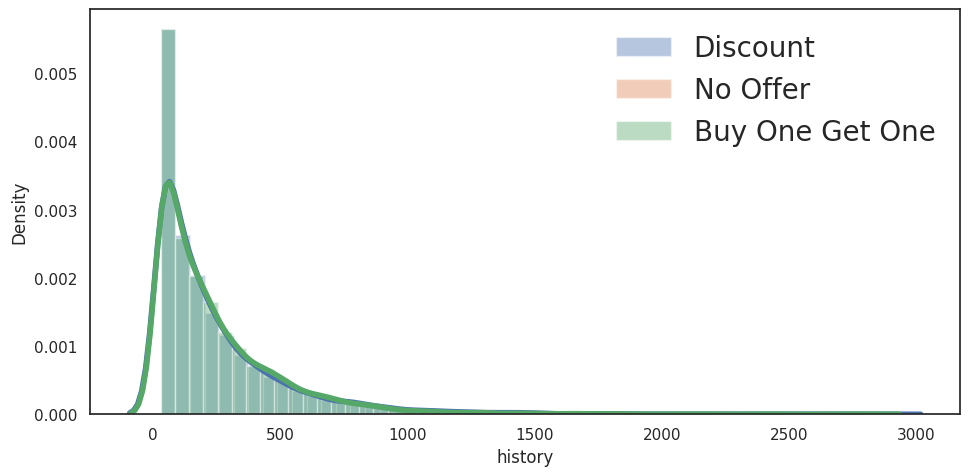

In [ ]:
# bins = 25
sns.distplot(is_treat.query("offer == 'Discount'").history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='Discount')
sns.distplot(is_treat.query("offer == 'No Offer'").history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='No Offer')
sns.distplot(is_treat.query("offer == 'Buy One Get One'").history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='Buy One Get One')
# sns.distplot(not_treat.history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

Check recency distribution by experiment group

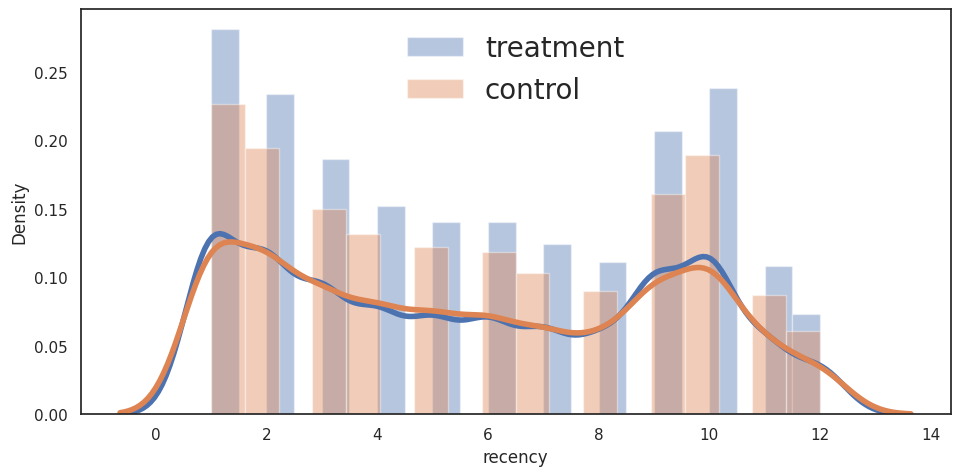

In [ ]:
# bins = 25
sns.distplot(is_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

##Modeling

In [ ]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
18455,10,95.64,1,0,0,Discount,0,True,False,True,False
44033,9,312.99,0,1,1,No Offer,0,True,False,False,False
60675,1,318.10,0,1,0,Discount,0,False,True,True,False
17443,11,99.42,1,0,1,Discount,0,True,False,False,True
15013,1,382.51,0,1,0,No Offer,0,False,True,True,False


In [ ]:
x_col = X_train.drop([treatment_variable, target_variable], axis = 1).columns.tolist()
print(x_col)

['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone', 'channel_Web']


##S-Learner

Define S-Learner (Classifier) using LGBMClassifier as base model

In [ ]:
slearner = BaseSClassifier(LGBMClassifier(), control_name=control_category)

**Estimate Average Treatment Effect**

In [ ]:
slearner.estimate_ate(X_train[x_col].values, X_train[treatment_variable].values, X_train[target_variable].values, bootstrap_ci  = True)

[LightGBM] [Info] Number of positive: 2747, number of negative: 18641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 21388, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128437 -> initscore=-1.914854
[LightGBM] [Info] Start training from score -1.914854
[LightGBM] [Info] Number of positive: 3122, number of negative: 18171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 21293, number of used features: 10
[LightGBM] [Info] [bin

array([0.0373357 , 0.07365402])

**Predict CATE for Each Treatment**

In [ ]:
slearner_tau = slearner.predict(X_test[x_col].values, X_test[treatment_variable].values, X_test[target_variable].values)

In [ ]:
slearner_tau

array([[0.01907151, 0.07139113],
       [0.01419895, 0.06971435],
       [0.00182487, 0.07437808],
       ...,
       [0.03412504, 0.08550652],
       [0.00364049, 0.10012243],
       [0.03410369, 0.02658574]])

Insert result to dataframe

In [ ]:
X_test['s_learner_tau'] = slearner_tau[:, 1] - slearner_tau[:, 0]

In [ ]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau
6102,3,314.42,0,1,0,Buy One Get One,0,False,True,False,True,0.052320
45109,1,1126.46,1,0,1,No Offer,0,True,False,False,True,0.055515
26217,2,50.39,1,0,0,Discount,1,False,True,False,True,0.072553
34041,5,156.34,1,0,0,Discount,0,False,True,False,True,0.141889
16367,7,382.71,1,1,0,Buy One Get One,0,False,False,False,False,0.215192


Check uplift distribution

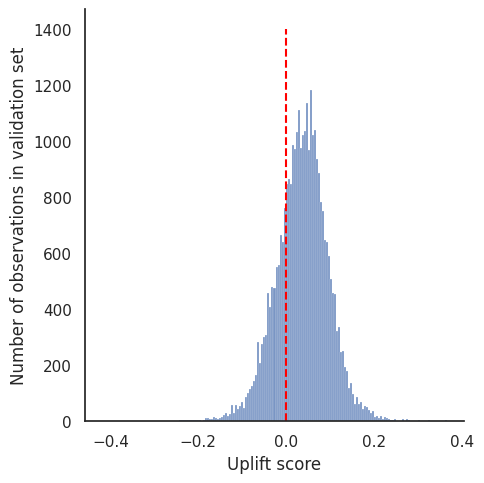

In [ ]:
# Uplift tree distribution
sns.displot(data = X_test['s_learner_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

##Uplift-Tree (Uplift Random Forest)

Define uplift random forest classifier

In [ ]:
uplift_model = UpliftRandomForestClassifier(control_name=control_category, random_state=1000)

Fit model to data

In [ ]:
uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train[treatment_variable].values,
    y = X_train[target_variable].values
)

Do prediction with trained model

In [ ]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

In [ ]:
y_pred.head()

,No Offer,Buy One Get One,Discount,recommended_treatment,delta_Buy One Get One,delta_Discount,max_delta
0,0.156885,0.184479,0.206551,2,0.027594,0.049666,0.049666
1,0.118674,0.164282,0.214443,2,0.045608,0.095769,0.095769
2,0.131796,0.129078,0.198862,2,-0.002717,0.067067,0.067067
3,0.143503,0.135178,0.208603,2,-0.008325,0.065100,0.065100
4,0.140228,0.168024,0.239130,2,0.027796,0.098902,0.098902


In [ ]:
# Capture the simplified uplift predictions
uplift_predictions = uplift_model.predict(X_test[x_col].values, full_output=False)

In [ ]:
uplift_predictions

array([[ 0.02759373,  0.0496661 ],
       [ 0.04560831,  0.09576939],
       [-0.00271749,  0.06706654],
       ...,
       [ 0.0473382 ,  0.07426103],
       [ 0.01739837,  0.07403283],
       [ 0.05988159,  0.06356158]])

In [ ]:
X_test['uplift_forest_tau'] = uplift_predictions[:, 1] - uplift_predictions[:, 0]

In [ ]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau,uplift_forest_tau
6102,3,314.42,0,1,0,Buy One Get One,0,False,True,False,True,0.052320,0.022072
45109,1,1126.46,1,0,1,No Offer,0,True,False,False,True,0.055515,0.050161
26217,2,50.39,1,0,0,Discount,1,False,True,False,True,0.072553,0.069784
34041,5,156.34,1,0,0,Discount,0,False,True,False,True,0.141889,0.073425
16367,7,382.71,1,1,0,Buy One Get One,0,False,False,False,False,0.215192,0.071106


Check uplift distribution

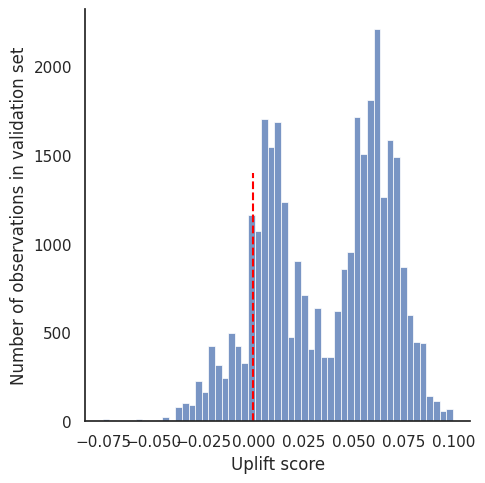

In [ ]:
sns.displot(data = X_test['uplift_forest_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

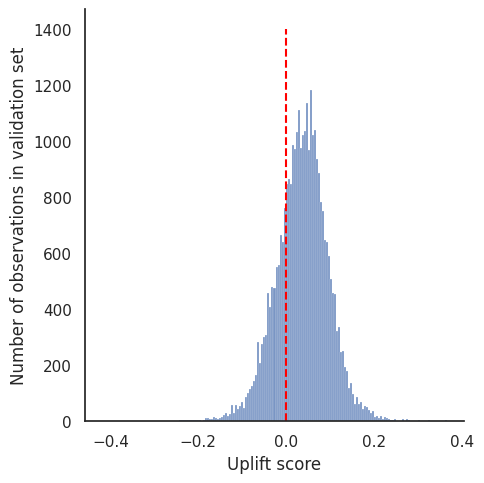

In [ ]:
sns.displot(data = X_test['s_learner_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

Model Evaluation

In [ ]:
def auuc_metric_maker(dataframe, tau_outcome_var, control_category, treatment_category):

  treatment_category_result = X_test[[tau_outcome_var]].reset_index(drop=True)
  treatment_category_result.columns = [treatment_category]

  # If all deltas are negative, assing to control; otherwise assign to the treatment
  # with the highest delta
  best_treatment = np.where(
      (treatment_category_result < 0).all(axis=1),
      control_category,
      treatment_category_result.idxmax(axis=1)
  )
  # Create indicator variables for whether a unit happened to have the
  # recommended treatment or was in the control group
  actual_is_best = np.where(dataframe[treatment_variable] == best_treatment, 1, 0)
  actual_is_control = np.where(dataframe[treatment_variable] == control_category, 1, 0)

  synthetic = (actual_is_best == 1) | (actual_is_control == 1)
  synth = treatment_category_result[synthetic]

  auuc_score = (synth.assign(
      is_treated = 1 - actual_is_control[synthetic],
      conversion = dataframe.loc[synthetic, target_variable].values,
      model_result = synth.max(axis=1)
  ).drop(columns=list([treatment_category]))).rename(columns = {"model_result": tau_outcome_var})

  return auuc_score

##S-Learner Evaluation

In [ ]:
slearner_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "s_learner_tau",
                                        control_category = control_category, treatment_category = treatment_category)

In [ ]:
slearner_auuc_score.head()

,is_treated,conversion,s_learner_tau
1,0,0,0.055515
2,1,1,0.072553
3,1,0,0.141889
5,1,0,0.046468
6,1,1,0.064599


In [ ]:
print(slearner_auuc_score.columns)


Index(['is_treated', 'conversion', 's_learner_tau'], dtype='object')


Calculate treated group based who visit our platform, treated or not

In [ ]:
slearner_auuc_score.groupby('is_treated').sum()[[target_variable]]

,conversion
is_treated,
0,1100
1,1471


##Uplift Forest

In [ ]:
uplift_forest_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "uplift_forest_tau",
                                             control_category = control_category, treatment_category = treatment_category)

In [ ]:
uplift_forest_auuc_score.head()

,is_treated,conversion,uplift_forest_tau
1,0,0,0.050161
2,1,1,0.069784
3,1,0,0.073425
5,1,0,0.071267
6,1,1,0.071815


##Cumulative Gain Plot

**S-Learner Model**

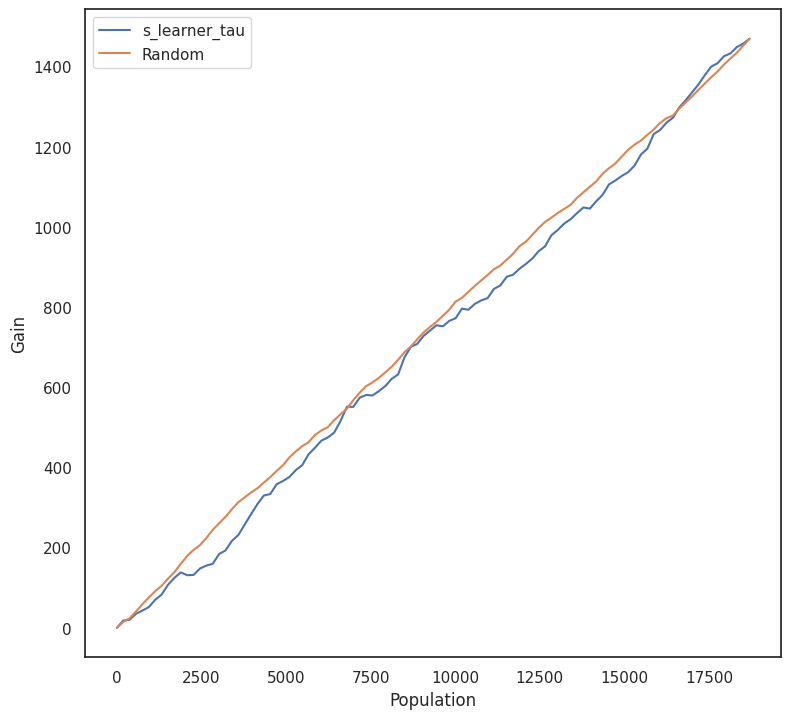

In [ ]:
metrics.plot_gain(slearner_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

**Uplift Forest Model**

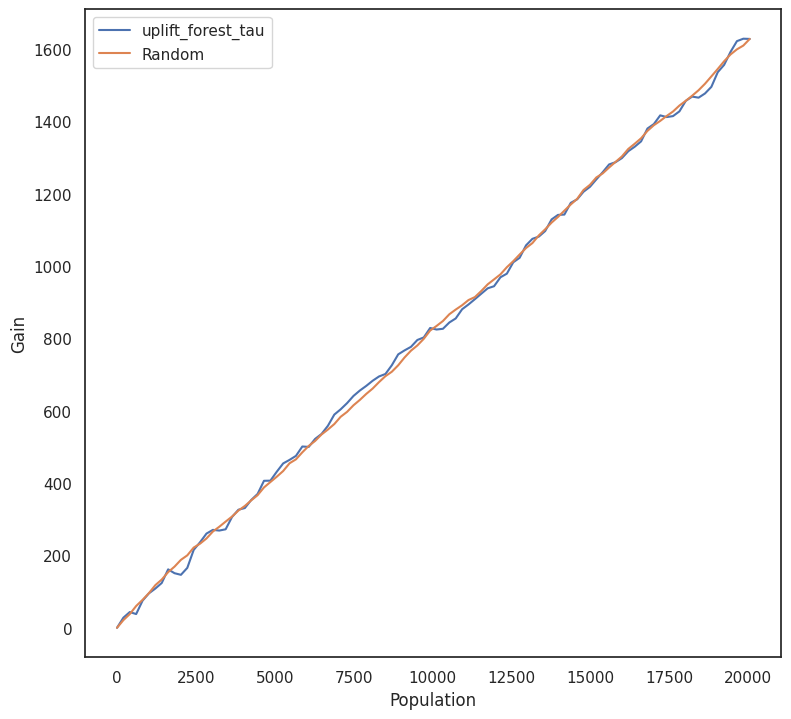

In [ ]:
metrics.plot_gain(uplift_forest_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

##AUUC and Qini Score

**AUUC for S-Learner**

In [ ]:
metrics.auuc_score(slearner_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

s_learner_tau    0.486535
Random           0.507343
dtype: float64

**AUUC for Uplift Forest**

In [ ]:
metrics.auuc_score(uplift_forest_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

uplift_forest_tau    0.503560
Random               0.503462
dtype: float64

**Qini Score for S-Learner**

In [ ]:
metrics.qini_score(slearner_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

s_learner_tau    0.050632
Random           0.000000
dtype: float64

**Qini Score for Uplift Forest**

In [ ]:
metrics.qini_score(uplift_forest_auuc_score, outcome_col=target_variable, treatment_col='is_treated')

uplift_forest_tau    0.031993
Random               0.000000
dtype: float64

##Quantile Metrics

Create new dataframe object

In [ ]:
X_test

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau,uplift_forest_tau
6102,3,314.42,0,1,0,Buy One Get One,0,False,True,False,True,0.052320,0.022072
45109,1,1126.46,1,0,1,No Offer,0,True,False,False,True,0.055515,0.050161
26217,2,50.39,1,0,0,Discount,1,False,True,False,True,0.072553,0.069784
34041,5,156.34,1,0,0,Discount,0,False,True,False,True,0.141889,0.073425
16367,7,382.71,1,1,0,Buy One Get One,0,False,False,False,False,0.215192,0.071106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56004,7,137.90,1,0,0,Discount,0,False,True,True,False,-0.010097,0.070496
38515,9,95.13,0,1,0,No Offer,0,True,False,False,True,0.042573,0.017098
57349,7,98.12,0,1,0,No Offer,0,False,True,False,True,0.051381,0.026923
39457,3,54.50,1,0,0,Buy One Get One,0,False,False,True,False,0.096482,0.056634


In [ ]:
def quantile_and_treatment(dataframe, tau_outcome_var, treatment_variable, control_category, treatment_category):
  # Bin uplift score by using quantile
  score_quantiles, score_quantile_bins = pd.qcut(
    x = dataframe[tau_outcome_var],
    q = 10,
    retbins = True,
    duplicates = 'drop'
  )
  dataframe['Quantile bin'] = score_quantiles
  # Calculate number of samples for each bins
  count_by_quantile_and_treatment = dataframe.groupby(['Quantile bin', treatment_variable])[treatment_variable].count().unstack(-1)
  return count_by_quantile_and_treatment[[control_category, treatment_category]]

In [ ]:
final_result = quantile_and_treatment(X_test, tau_outcome_var = "uplift_forest_tau", treatment_variable = treatment_variable, control_category = control_category, treatment_category = treatment_category)

**Visualize the impact of the treatment**

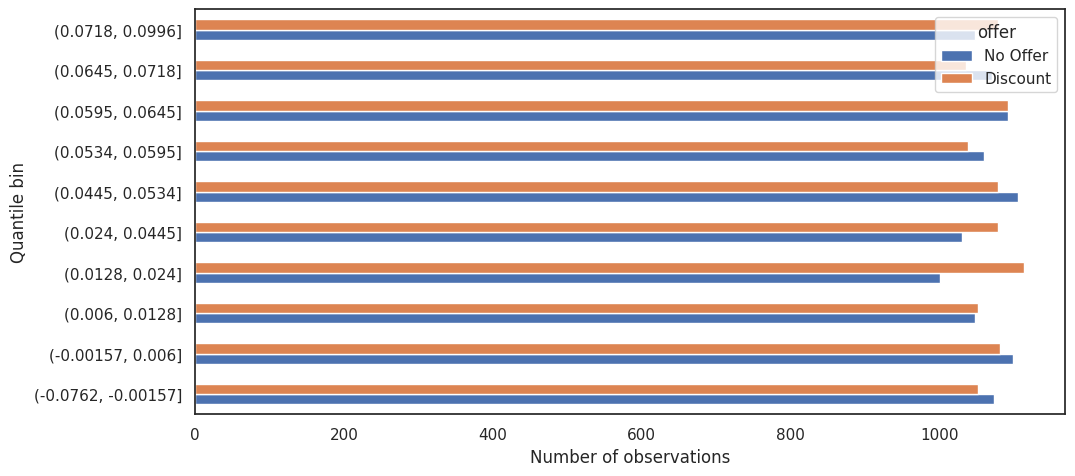

In [ ]:
final_result.plot.barh()
plt.xlabel('Number of observations');

##Uplift Quantile Chart

In [ ]:
def true_uplift(dataframe, tau_outcome_var, target_variable, treatment_variable, treatment_category, ):
  # Bin uplift score by using quantile
  score_quantiles, score_quantile_bins = pd.qcut(
    x = dataframe[tau_outcome_var],
    q = 10,
    retbins = True,
    duplicates = 'drop'
  )

  dataframe['Quantile bin'] = score_quantiles
  # Get the conversion rates within uplift score quantiles for both groups
  validation_treatment_mask = dataframe[treatment_variable] == treatment_category
  treatment_by_quantile = dataframe[validation_treatment_mask]\
    .groupby('Quantile bin')[target_variable].mean()
  control_by_quantile = dataframe[~validation_treatment_mask]\
    .groupby('Quantile bin')[target_variable].mean()
  # calculate true uplift
  true_uplift_by_quantile = treatment_by_quantile - control_by_quantile
  return true_uplift_by_quantile

In [ ]:
true_uplift_result = true_uplift(X_test, tau_outcome_var = "uplift_forest_tau", target_variable = target_variable, treatment_variable = treatment_variable, treatment_category = treatment_category)

In [ ]:
true_uplift_result.head(5)

Quantile bin
(-0.0762, -0.00157]    0.029202
(-0.00157, 0.006]      0.021210
(0.006, 0.0128]        0.048829
(0.0128, 0.024]        0.038974
(0.024, 0.0445]        0.048667
Name: conversion, dtype: float64

Visualize uplift quantile chart

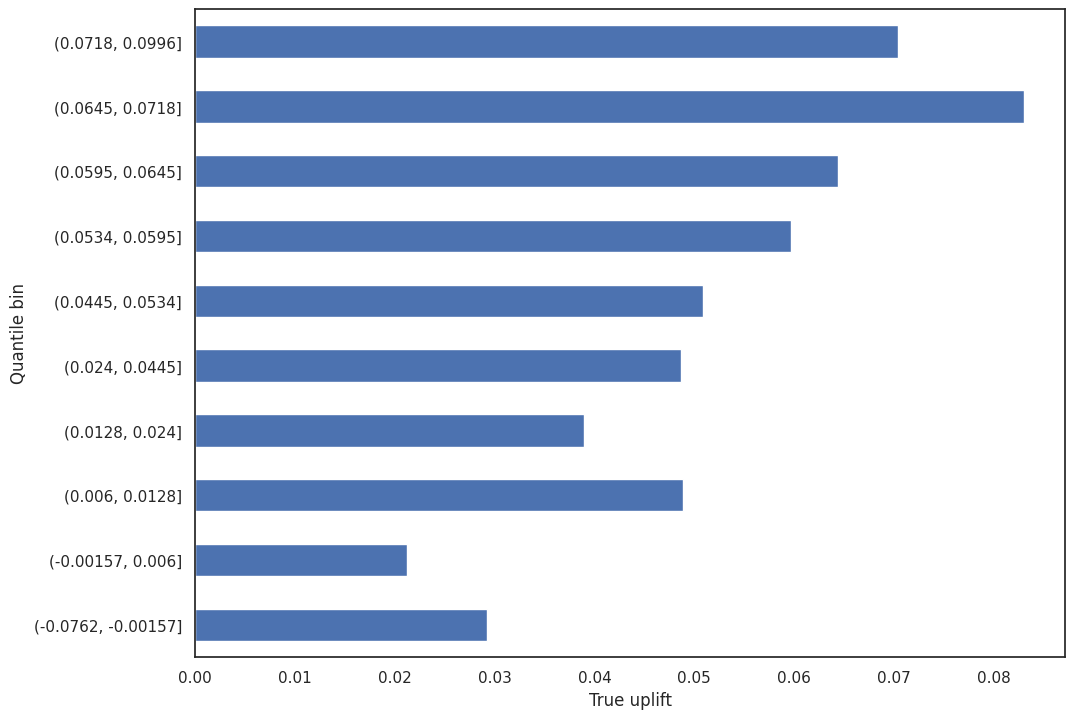

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
true_uplift_result.plot.barh()
plt.xlabel('True uplift');

##Model Interpretation

####Feature Importance (Gain, Permutation, etc)

In [ ]:
print(X_test['s_learner_tau'].shape)


(32000,)


In [ ]:
tau_reshaped = X_test['s_learner_tau'].values.reshape(-1, 1)

In [ ]:
tau_reshaped

array([[ 0.05231961],
       [ 0.0555154 ],
       [ 0.0725532 ],
       ...,
       [ 0.05138147],
       [ 0.09648194],
       [-0.00751796]])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

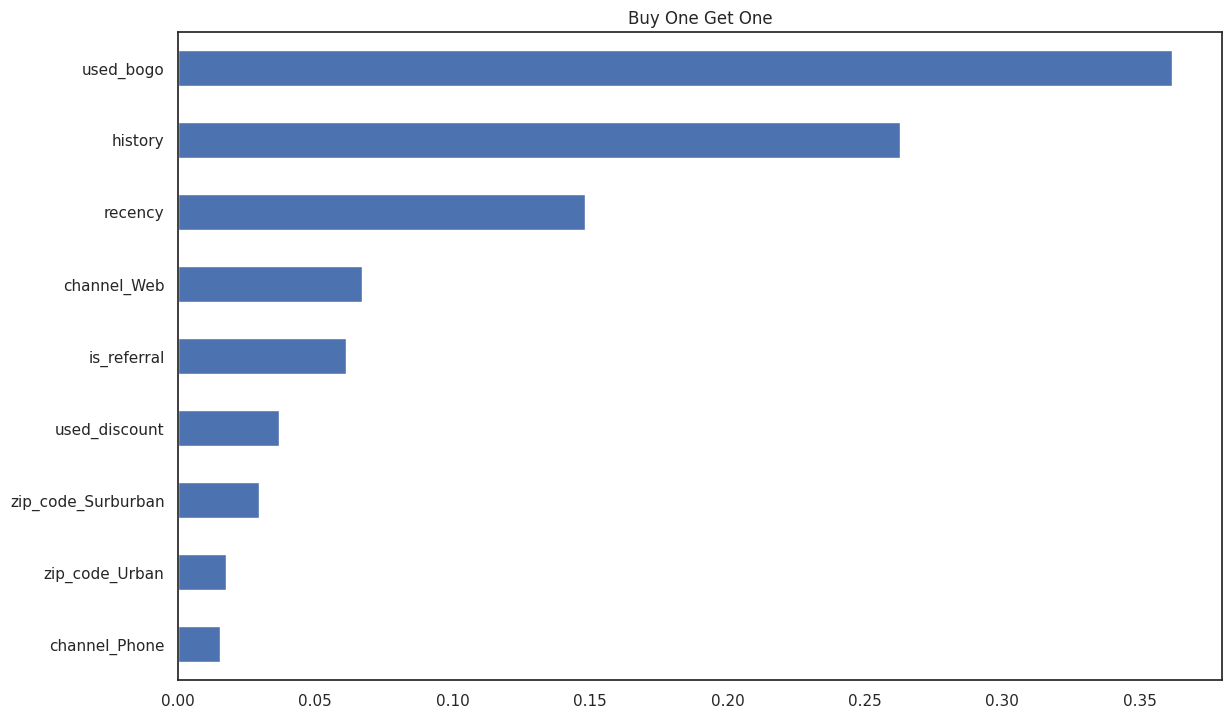

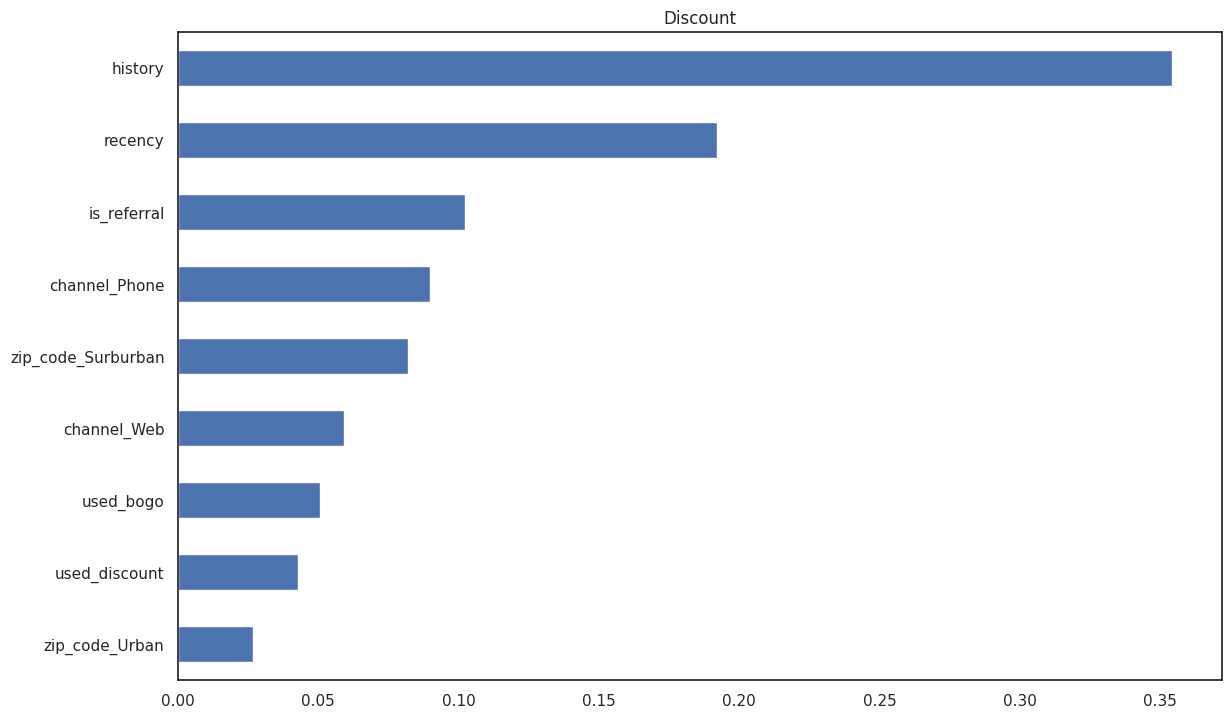

In [ ]:
# Assuming 'slearner_tau' is still available in its original form
slearner.plot_importance(
    X=X_test[x_col],
    tau=slearner_tau,  # Here, use the original tau data
    method='auto',
    random_state=42,
    features=x_col
)


##Shapley Dependence Model

**Shape Value for History**

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

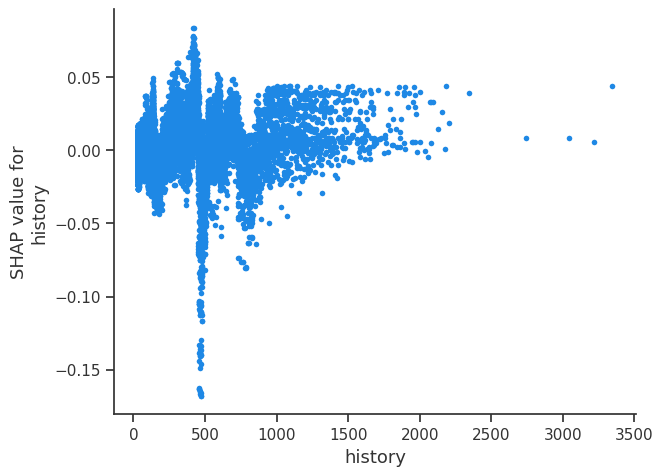

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=treatment_category,
    feature_idx='history',
    X=X_test[x_col].values,
    features = x_col,
    tau= slearner_tau,
    interaction_idx=None
)

**Shap Value for Recency**

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

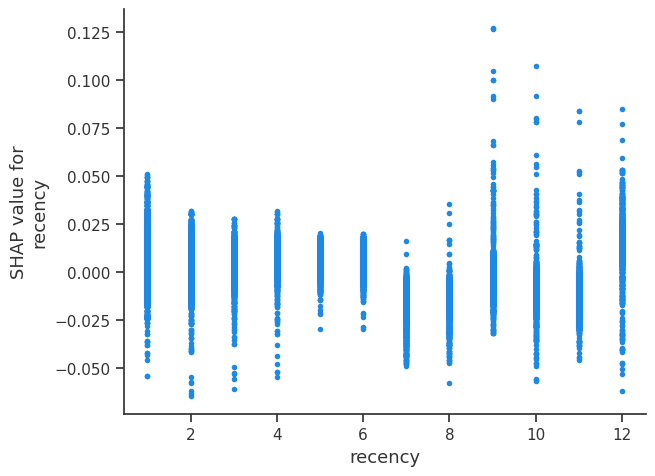

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=treatment_category,
    feature_idx='recency',
    X=X_test[x_col].values,
    features = x_col,
    tau= slearner_tau,
    interaction_idx=None
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

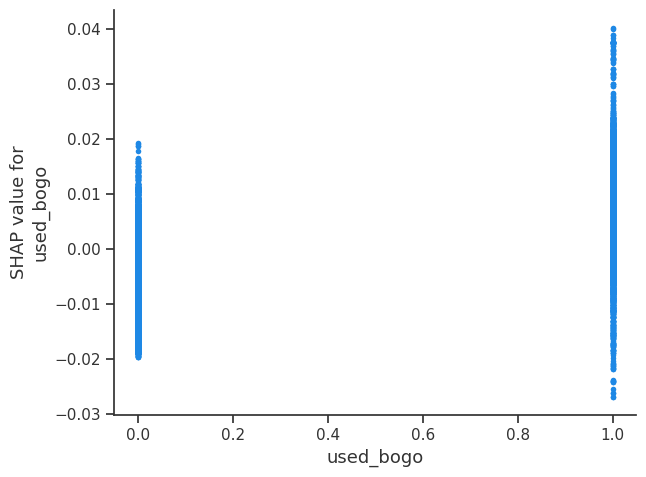

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=treatment_category,
    feature_idx='used_bogo',
    X=X_test[x_col].values,
    features = x_col,
    tau= slearner_tau,
    interaction_idx=None
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

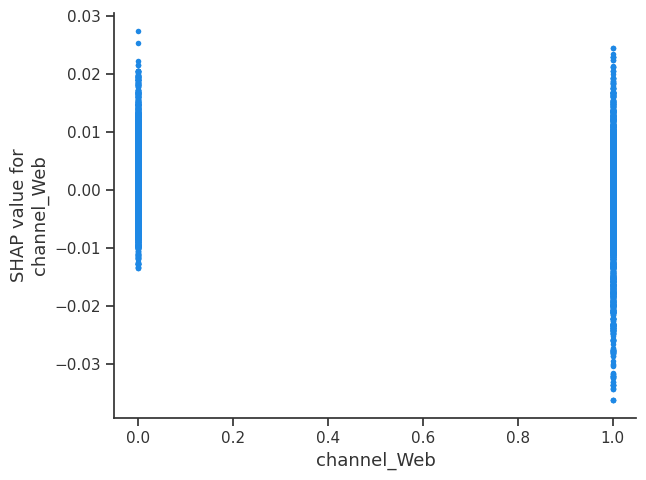

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=treatment_category,
    feature_idx='channel_Web',
    X=X_test[x_col].values,
    features = x_col,
    tau= slearner_tau,
    interaction_idx=None
)

##Special Explanation Method for Tree-Based Model

###Feature Importance

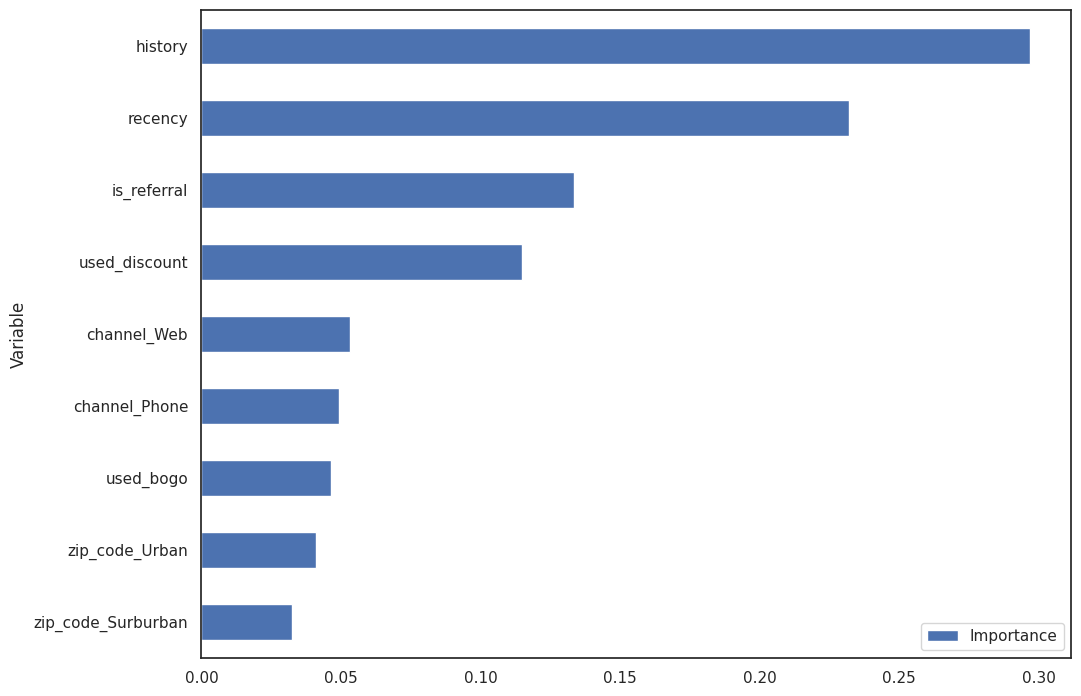

In [ ]:
pd.DataFrame(
    {
        "Variable": x_col,
        "Importance": uplift_model.feature_importances_
    }
).sort_values(by="Importance", ascending = True).plot(x = 'Variable', y = 'Importance', kind = 'barh');

###Tree Rules

In [ ]:
uplift_tree = uplift_model.uplift_forest[0]

In [ ]:
# Print uplift tree as a string
uplift_tree_string(uplift_tree.fitted_uplift_tree, x_col)

is_referral >= 0.1?
yes -> history >= 50.222?
		yes -> recency >= 2.0?
				yes -> recency >= 4.0?
						yes -> [0.06833268254588051, 0.10182975338106603, 0.12543285879184302]
						no  -> [0.07628865979381444, 0.1596244131455399, 0.18475073313782991]
				no  -> zip_code_Surburban >= 0.1?
						yes -> [0.13803680981595093, 0.2636363636363636, 0.2698412698412698]
						no  -> [0.18795180722891566, 0.145679012345679, 0.17714285714285713]
		no  -> channel_Web >= 0.1?
				yes -> recency >= 3.0?
						yes -> [0.044444444444444446, 0.14505494505494507, 0.14043583535108958]
						no  -> [0.10752688172043011, 0.15384615384615385, 0.17272727272727273]
				no  -> recency >= 7.0?
						yes -> [0.0, 0.08633093525179857, 0.04195804195804196]
						no  -> [0.039525691699604744, 0.09016393442622951, 0.17054263565891473]
no  -> used_bogo >= 0.1?
		yes -> channel_Web >= 0.1?
				yes -> history >= 75.718?
						yes -> [0.19701810436634717, 0.1834763948497854, 0.2668213457076566]
						no  -> [0.151670951

##Tree Visualizer

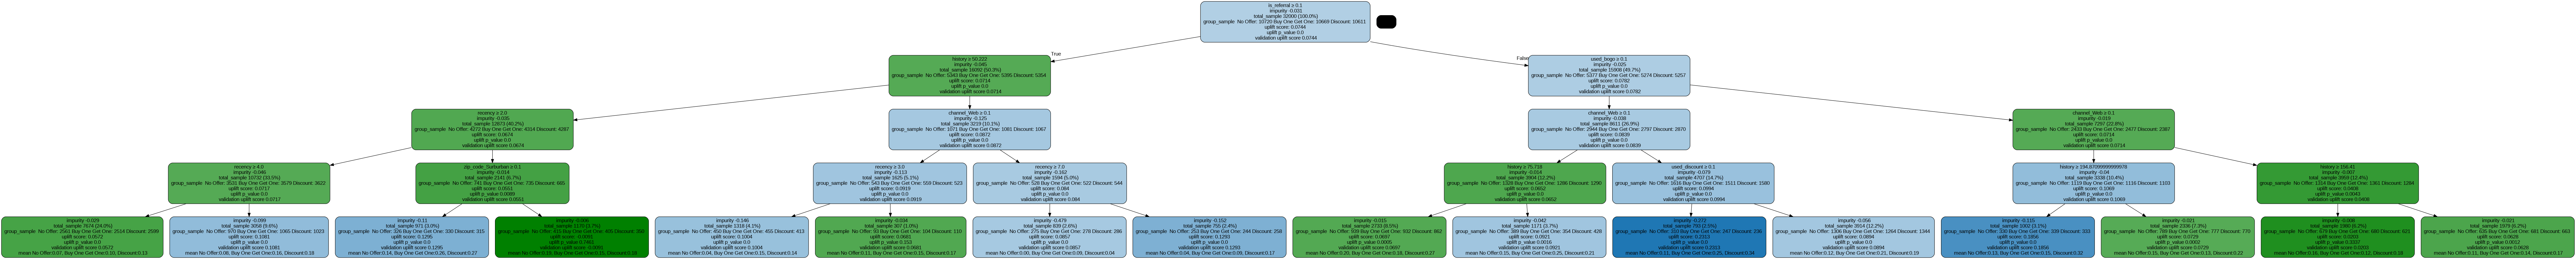

In [ ]:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, x_col)
Image(graph.create_png())